# **Lab 10: Reinforcement Learning with OpenAI Gym**

In [4]:
import gym
from gym import envs
import numpy as np 
import datetime
import keras 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd 
from time import sleep
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings
import random
from IPython.display import clear_output
warnings.filterwarnings('ignore')

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
/home/bolunlin/anaconda3/envs/REIN/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# **0. Gym**

Gym is released by Open AI in 2016 (http://gym.openai.com/docs/). Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow.

The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

There are many environments that you can learn more. http://gym.openai.com/envs/


<img src="enviroment.png" alt="enviroment" width="500"   align="center" />


# **1. Intro to taxi game environment**

The aim of the taxi game is to make sure the taxi can get to the passenger, pick him up and bring him to the drop-off location in the fastest way possible.



**Representations**


<table >
    <tr><th>Symbol</th><th>Representation</th><th>Example</th></tr>
    <tr><td>|</td><td>WALL (Can't pass through)</td><td rowspan = '6' > <img src="taxi.png" alt="taxi"   align="center" />  <td></tr>
    <tr><td>Yellow bar</td><td>Taxi Current Location </td></tr>
    <tr><td>Letters</td><td>Locations </td></tr>
    <tr><td>Blue letter</td><td> Pick up Location  </td></tr>
      <tr><td>urple letter</td><td> Drop-off Location   </td></tr>
        <tr><td>Green letter </td><td> Taxi turn green once passenger board   </td></tr>
   </table>




In [2]:
env = gym.make('Taxi-v3') # load taxi enviroment
env.reset()# initalize the vironment and this will return a integer
env.render() ## visualize the current state

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



You will notice that **env.reset() resetting the environment** will return an integer. This number will be our initial state. All possible states in this environment are represented by an integer ranging from 0 to 499. We can determine the total number of possible states using the following command:

In [3]:
env.observation_space.n   #Total no. of states

500

**Actions (6 in total)**

- 0: move south
- 1: move north
- 2: move east 
- 3: move west 
- 4: pickup passenger
- 5: dropoff passenger

In [4]:
env.action_space.n   #Total no. of actions

6

In [5]:
env.env.s = 122
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
env.step(3)

(102, -1, False, {'prob': 1.0})

Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

The 4 elements returned are:

-  **Observation (object)**: the state the environment is in or an environment-specific object representing your observation of the environment.
-  **Reward (float)**: Reward achieved by the previous action. 
    -  +20: Last step when we successfully pick up a passenger and drop them off at their desired location
    -  -1: for each step in order for the agent to try and find the quickest solution possible
    -  -10: every time you incorrectly pick up or drop off a passenger
-  **Done (boolean)**: whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, you lost your last life.)
-  **Info (dict)**: Can be ignored, diagnostic information useful for debugging. Official evaluations of your agent are not allowed to use this for learning.

In [7]:
env.render()  #view state

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


The function (env.P) below can be used to see the relevant states and rewards for each action taken in that particular state.

In [8]:
env.reset()
env.env.P[300]

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

# **2. Random Search**
Let's start with the simplest way to train our agent to complete this task. The agent would just take random steps at every state until he completes the task (picking the passenger and dropping him off at the drop-off location). 

## 2.1 Create the environment
We use the Taxi-v3 as our environment.

In [9]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 2.2 Define random search method

- This function will return counts that the method how many steps to complete this task. 

In [10]:
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter


## 2.3  Let's use Random Search to complete the task

An agent using Random search takes about an average of 2461 steps to successfully complete its mission.


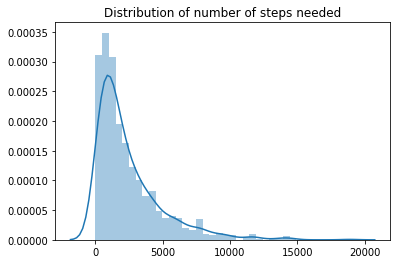

In [11]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")
print("An agent using Random search takes about an average of"" " + str(int(np.mean(counts)))
      + " ""steps to successfully complete its mission.")

Clearly, it is not the most efficient way to complete this. Let's try to use Q-learning with epsilon-greedy method to more effectively let our agent complete this task. 

# **3.Q-learning with epsilon-greedy method** 

## 3.1 Create the environment
We use the Taxi-v3 as our environment.

In [12]:
env = gym.make('Taxi-v3')
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



## 3.2 The Q-learning algorithm

The algorithm for Q-learning is as follows:

- Step 1 : Initialize the Q-table by all zeros.
- Step 2 : Create the hyperparameters  learning rate, gamma, episodes, epsilon, decay_rate, max_epsilon, min_epsilon
- Step 3: Start exploring actions: For each state, select any one among all possible actions for the current state (S) and travel to the next state (S') as a result of that action (a).
- Step 4  : Update Q-table value :For all possible actions from the state (S') select the one with the highest Q-value with probability (1-epsilon) and select a random action with probability (epsilon).   
This is to balance the exploration and exploitation actions. using the equation:  **Q(state,action) <- (1−α) * Q(state,action) + α(reward + γ * max<sub>a</sub>Q(next state,all actions))**
- Step 5 : Set the next state as the current state. If goal state is reached, then end and repeat the process.

### 3.3.1 Initialize the Q-table
We initialize the Q-table by all zeros.  
Q-table shape will be **State size ×Action size**

In [13]:
action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.n
print("State size ", state_size)

Action size  6
State size  500


In [14]:
Q_table = np.zeros([state_size, action_size])   ## CODE HERE##
print("Q table shape is ",Q_table.shape)
print(Q_table)

Q table shape is  (500, 6)
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


Outputs  Should be  
Q table shape is  (500, 6)  
[[0. 0. 0. 0. 0. 0.]  
 [0. 0. 0. 0. 0. 0.]  
 [0. 0. 0. 0. 0. 0.]  
 ...  
 [0. 0. 0. 0. 0. 0.]  
 [0. 0. 0. 0. 0. 0.]  
 [0. 0. 0. 0. 0. 0.]]

### 3.3.2 Create the hyperparameters
This cell will  set up the following Q learning hyperparameters.
1. **alpha** :  Learning Rate --> Extent to which our Q-values are being updated in every iteration.
2. **gamma** :  Discount Rate --> How much importance we want to give to future rewards
3. **epsilon** : Exploration Rate --> Probability of selecting random action instead of the 'optimal' action
4. **episodes**: Total episodes to train on  
&emsp; **max_epsilon**  : Exploration probability at start  
&emsp; **min_epsilon** : Minimum exploration probability   
&emsp; **decay_rate** :Exponential decay rate for exploration prob  

In [15]:
alpha = 0.7           # Learning rate
gamma = 0.618                 # Discounting rate

episodes = 50000        # Total episodes

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.01             # Exponential decay rate for exploration prob

### 3.3.3 Action function
We choose a random number as action   
**hint** use [random.uniform()](https://docs.python.org/3/library/random.html) function to create number between 0 and  1


**if the number greater than epsilon**  
&emsp;  take the biggest Q value for this state.

**else**  
&emsp;  use a random action as our choice 



In [1]:
def act(Q_table , epsilon,state):
    """ 
    Args:
        Q_table : current Q-table
        epsilon:  probability of selecting random action instead of the 'optimal' action
        state: current state
    Returns:
        action :  action based on the current state 

    """    
    random_number_tradeoff = random.uniform(0, 1) ## CODE HERE##
    if random_number_tradeoff > epsilon:
        action = np.argmax(Q_table[state]) # Exploit learned values by choosing max values    ## CODE HERE##  
    else:
        action = env.action_space.sample() # Explore action space randomly     
    return action

### 3.3.4 Update function

Update Q-table values using the equation:  **Q(state,action) <- (1−α) * Q(state,action) + α(reward + γ * max<sub>a</sub>Q(next state,all actions))**

In [2]:
 def update(Q_table,state,action,next_state,reward,alpha,gamma):
    """

    Args:
        Q_table : current Q-table
        state : current state
        action : current action
        next_state : next state
        reward : reward in the current action
        alpha : learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma : discount Rate --> How much importance we want to give to future rewards
    Returns:
        updated Q-learning  table 

    """
    old_value = Q_table[state, action]
    next_max = np.max(Q_table[next_state])

    Q_table[state, action]  = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)    ## CODE HERE##
    return  Q_table

### 3.3.5 Q learning train function
Merge action and update function to trains Q table

loop episodes times:  
&emsp; reset our environment  
&emsp; while not done:  
&emsp; &emsp; choose an optimal **action**   
&emsp; &emsp; execution action  
&emsp; &emsp; **update** our Q-table  
&emsp; &emsp; use the state for next action

In [3]:
def Q_learning_train(env,alpha,Q_table,gamma,epsilon,episodes): 
    """Q Learning Algorithm with epsilon greedy 

    Args:
        env: environment 
        Q_table : initialized q-table 
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: discount Rate --> How much importance we want to give to future rewards
        epsilon: probability of selecting random action instead of the 'optimal' action
        episodes: number of episodes to train on

    Returns:
        Q-learning Trained table

    """
    
    for episode in range(1, episodes+1):
        
        state = env.reset()
        done = False

        while not done:
           
            action= act(Q_table , epsilon,state)  #### CODE　HERE#### ## hint : call act() finction
            
            next_state, reward, done, info = env.step(action) 
            
            Q_table = update(Q_table,state,action,next_state,reward,alpha,gamma) #### CODE　HERE#### ## hint : call update() finction

            state = next_state
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
        if episode % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {episode}")
    print("Training finished.\n")
    return Q_table    

### 3.3.6 Let's train our Q-table

In [28]:
env = gym.make('Taxi-v3')
env.reset()
Q_table = Q_learning_train(env,alpha,Q_table,gamma,epsilon,episodes)

Episode: 50000
Training finished.



### 3.3.7 Create our Q learning policy
 we will our trained Q-table create a policy matrix that each states should have a best action.

In [29]:
## initial our policy matrix
policy = np.zeros([env.env.nS, env.env.nA]) / env.env.nA

for state in range(env.env.nS):  #for each states
    best_act = np.argmax(Q_table[state]) #find best action in this state ### CODE HERE ### hint np.argmax()
    policy[state] = np.eye(env.env.nA)[best_act]  #update 
        

### 3.3.8 Count function
Count how many average  steps  the policy will use in each taxi game.

In [30]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    done = False
    while not done:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been improved using Q-learning takes about an average of 13 steps to successfully complete its mission.


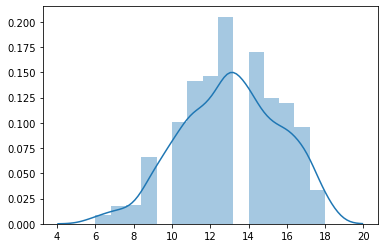

In [32]:
Q_Learning_counts = count(policy)
Q_counts = [count(policy) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of " + str(int(np.mean(Q_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(Q_counts)

### 3.3.9 Use our Q-table to play Taxi ! 
After 50 000 episodes, our Q-table can be used as a "cheatsheet" to play Taxi.  
By running this cell you can see our agent playing Taxi.

In [33]:
rewards = []
counts =[]
total_test_episodes = 100   ## We try 100 episodes in our test 
for episode in range(total_test_episodes):
    state = env.reset()
    done = False
    total_rewards = 0
    count = 0
    while not done:
        
        action = np.argmax(Q_table[state])  # Take the action (index) that have the maximum expected future reward given that state 
        
        new_state, reward, done, info = env.step(action) 
        
        total_rewards += reward
        count +=1
        if done:
            rewards.append(total_rewards)
            counts.append(count)
            break
        state = new_state
env.close()
print ("Use Q-learning takes about an average "+str(sum(rewards)/total_test_episodes) +" in the taxi game." )
print ("Use Q-learning takes about an average of "+str(sum(counts)/total_test_episodes) +" to successfully finish the taxi game." ) 

Use Q-learning takes about an average 7.89 in the taxi game.
Use Q-learning takes about an average of 13.11 to successfully finish the taxi game.


# **4. Let's watch how our Q-learning works in action**

We can also view it animated by running the function below. 

In [35]:
from IPython.display import clear_output

from matplotlib import animation
from IPython.display import display


def view_policy_anim(policy):
    penalties, reward = 0, 0

    frames = [] # for animation

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    def print_frames(frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['frame'])
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.2)

    print_frames(frames)

In [36]:
view_policy_anim(policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 12
State: 0
Action: 5
Reward: 20
